# Moisture Guard (Tinkercad) — Predict **Time to Dry Event** (30% / Watering Trigger)

This notebook is tailored for my Arduino/Tinkercad CSV format:

`ms,raw,percent,stateId`

**stateId mapping**
- 0 = WET  
- 1 = NORMAL  
- 2 = DRY  
- 3 = WATERING  
- 4 = COOLDOWN  

## What we predict
Instead of "time to 30%" only, we predict **time to the dry event**, defined as the next time when:
- `percent <= 30` **OR**
- watering starts (`stateId == 3`)

This matches system behavior (watering may start before many samples appear below 30%).




## 1) Load data (Option A: upload a CSV)
Run the next cell and upload your CSV file.


In [13]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()  # upload your CSV (ms,raw,percent,stateId)
csv_name = list(uploaded.keys())[0]

df = pd.read_csv(csv_name)

# Basic checks
df = df.dropna()
df["ms"] = df["ms"].astype(int)
df["raw"] = df["raw"].astype(int)
df["percent"] = df["percent"].astype(int)
df["stateId"] = df["stateId"].astype(int)

df["t_sec"] = df["ms"] / 1000.0

print("Rows:", len(df))
print("State counts:\n", df["stateId"].value_counts())
df.head()


Saving moisture_log_augmented.csv to moisture_log_augmented (1).csv
Rows: 259
State counts:
 stateId
0    75
1    65
4    64
3    55
Name: count, dtype: int64


,ms,raw,percent,stateId,t_sec
0,179,102,90,4,0.179
1,13452,102,90,4,13.452
2,13724,102,90,4,13.724
3,13997,102,90,4,13.997
4,14269,102,90,4,14.269


## (Optional) Load data (Option B: paste Serial Monitor text)
If you don't want to upload a file, paste your lines into `raw_text` below, then run.


In [14]:
# Uncomment and use this ONLY if you prefer paste instead of upload.
# raw_text = """
# 179,102,90,4
# 13452,102,90,4
# ...
# """

# rows = []
# for line in raw_text.splitlines():
#     line = line.strip()
#     if not line:
#         continue
#     parts = line.split(",")
#     if len(parts) != 4:
#         continue
#     rows.append([int(x) for x in parts])
#
# df = pd.DataFrame(rows, columns=["ms","raw","percent","stateId"])
# df["t_sec"] = df["ms"]/1000.0
#
# print("Rows:", len(df))
# print("State counts:\n", df["stateId"].value_counts())
# df.head()


## 2) Visualize moisture over time


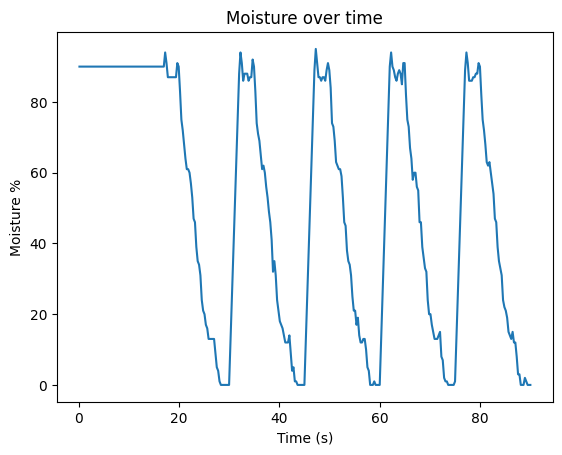

In [15]:
plt.figure()
plt.plot(df["t_sec"], df["percent"])
plt.xlabel("Time (s)")
plt.ylabel("Moisture %")
plt.title("Moisture over time")
plt.show()


## 3) Build the label: **time_to_dry_event_sec**
Dry event = next time when `percent <= 30` OR `stateId == 3` (watering starts).
We compute, for each row (while in WET/NORMAL and above 30%), how many seconds remain until that event.


In [16]:
threshold = 30

p = df["percent"].to_numpy()
t = df["t_sec"].to_numpy()
s = df["stateId"].to_numpy()

event = (p <= threshold) | (s == 3)  # dry event definition

# next event index for each i (scan backwards)
next_event = np.full(len(df), -1, dtype=int)
j = -1
for i in range(len(df)-1, -1, -1):
    if event[i]:
        j = i
    next_event[i] = j

y = np.full(len(df), np.nan, dtype=float)
for i in range(len(df)):
    j = next_event[i]
    # only learn/predict in normal operation (wet/normal) and above threshold
    if j != -1 and (s[i] in [0,1]) and p[i] > threshold and j > i:
        y[i] = t[j] - t[i]

df["time_to_dry_event_sec"] = y

print("Labeled rows:", np.sum(~np.isnan(y)))
df[["t_sec","percent","stateId","time_to_dry_event_sec"]].dropna().head(12)


Labeled rows: 140


,t_sec,percent,stateId,time_to_dry_event_sec
14,16.991,90,0,7.567
15,17.260,94,0,7.298
16,17.529,91,0,7.029
17,17.800,87,0,6.758
18,18.069,87,0,6.489
19,18.338,87,0,6.220
20,18.608,87,0,5.950
21,18.877,87,0,5.681
22,19.147,87,0,5.411
23,19.417,87,0,5.141


## 4) Feature engineering
We use simple, explainable features:
- current moisture percent
- slope over last window seconds (trend)
- rolling mean / rolling std
- stateId (0/1 here)


In [17]:
# Estimate sample period to choose a reasonable rolling window
dt_est = np.median(np.diff(df["t_sec"].to_numpy()))
dt_est = float(dt_est) if np.isfinite(dt_est) and dt_est > 0 else 0.25
print("Estimated dt (sec):", dt_est)

# Choose ~8 seconds window by default (works well for short logs)
window_sec = 8.0
window = max(5, int(round(window_sec / dt_est)))
print("Rolling window (samples):", window)

df["p"] = df["percent"].astype(float)
df["p_mean"] = df["p"].rolling(window, min_periods=window).mean()
df["p_std"]  = df["p"].rolling(window, min_periods=window).std()

# slope via linear fit on the last window points
slopes = np.full(len(df), np.nan)
t_vals = df["t_sec"].to_numpy()
p_vals = df["p"].to_numpy()

for i in range(window-1, len(df)):
    tt = t_vals[i-window+1:i+1]
    pp = p_vals[i-window+1:i+1]
    slopes[i] = np.polyfit(tt, pp, 1)[0]  # % per second

df["slope"] = slopes

data = df.dropna(subset=["time_to_dry_event_sec","p_mean","p_std","slope"]).copy()
data = data[data["stateId"].isin([0,1])]          # learn from wet/normal
data = data[data["percent"] > threshold]          # only above threshold

print("Training rows:", len(data))
data[["t_sec","percent","slope","p_mean","p_std","stateId","time_to_dry_event_sec"]].head()


Estimated dt (sec): 0.2710000000000008
Rolling window (samples): 30
Training rows: 125


,t_sec,percent,slope,p_mean,p_std,stateId,time_to_dry_event_sec
29,21.033,68,-0.662911,87.433333,5.769619,1,3.525
30,21.305,64,-2.022760,86.566667,7.156783,1,3.253
31,21.575,61,-2.545535,85.600000,8.508008,1,2.983
32,21.847,61,-3.021295,84.633333,9.571810,1,2.711
33,22.118,60,-3.473502,83.633333,10.512663,1,2.440


## 5) Baseline (no ML): slope estimate
A simple physics-style estimate:

`time_to_event ≈ (percent - 30) / abs(slope)`

This is a strong baseline and good to mention in your README.


In [18]:
EPS = 0.02   # (% per second) اعتبر أقل من كده = slope ضعيف/مش جفاف حقيقي

mask = data["slope"] < -EPS   # بس لما slope سالب بوضوح

baseline = (data.loc[mask, "percent"] - threshold) / (-data.loc[mask, "slope"])
baseline = baseline.clip(lower=0)

mae_baseline = np.mean(np.abs(baseline - data.loc[mask, "time_to_dry_event_sec"]))

print("Rows used for baseline:", mask.sum(), "out of", len(data))
print("Filtered Baseline MAE (sec):", round(mae_baseline, 2))
print("Share ignored (slope >= -EPS):", round((~mask).mean()*100, 1), "%")


Rows used for baseline: 25 out of 125
Filtered Baseline MAE (sec): 20.99
Share ignored (slope >= -EPS): 80.0 %


## 6) ML model: Linear Regression (time-based split)
We split by time (first 80% train, last 20% test) to avoid leakage.


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X = data[["percent","slope","p_mean","p_std","stateId"]]
y = data["time_to_dry_event_sec"]

cut = int(len(data) * 0.8)
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)

print("Linear Regression MAE (sec):", round(mae, 2))


Linear Regression MAE (sec): 0.17


## 7) Plots: Predicted vs Actual (test)


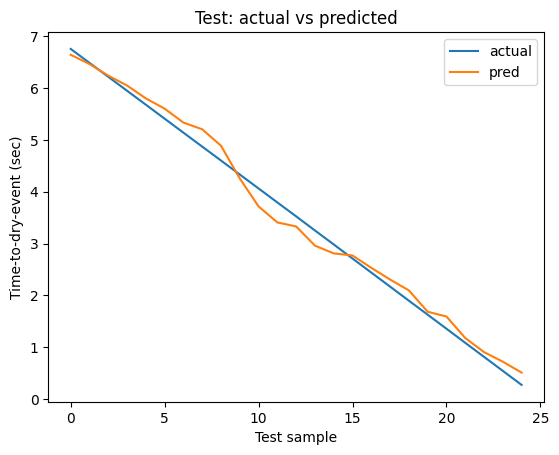

In [20]:
plt.figure()
plt.plot(y_test.to_numpy(), label="actual")
plt.plot(pred, label="pred")
plt.xlabel("Test sample")
plt.ylabel("Time-to-dry-event (sec)")
plt.title("Test: actual vs predicted")
plt.legend()
plt.show()


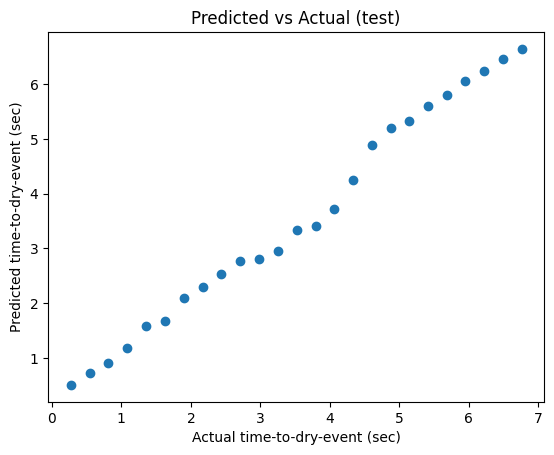

In [21]:
# Scatter: predicted vs actual (test)
plt.figure()
plt.scatter(y_test.to_numpy(), pred)
plt.xlabel("Actual time-to-dry-event (sec)")
plt.ylabel("Predicted time-to-dry-event (sec)")
plt.title("Predicted vs Actual (test)")
plt.show()


## 8) Use the model to create a proactive decision (demo)
Example: if predicted time-to-event <= 120 sec, we trigger a **"Water soon"** warning.


In [22]:
ALERT_SEC = 120

data = data.copy()
data["pred_time_to_event"] = model.predict(data[["percent","slope","p_mean","p_std","stateId"]])
data["water_soon"] = (data["pred_time_to_event"] <= ALERT_SEC).astype(int)

data[["t_sec","percent","pred_time_to_event","water_soon"]].tail(12)


,t_sec,percent,pred_time_to_event,water_soon
226,81.349,63,2.960231,1
227,81.619,62,2.810172,1
228,81.891,63,2.769909,1
229,82.162,60,2.531671,1
230,82.433,57,2.305342,1
231,82.705,54,2.095715,1
232,82.975,47,1.683777,1
233,83.246,46,1.591911,1
234,83.518,39,1.176631,1
235,83.789,35,0.904154,1
